# Entrenamiento con otros modelos

A continuación voy a entrenar otros modelos para ver si existe alguna alternativa mejor al modelo RandomForest que he empleado inicialmente.

Empiezo importando las librerías y el dataset que voy a necesitar.

In [69]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas.io

import matplotlib.pyplot as plt

import librosa.display
import librosa

from glob import glob

import ffmpeg

import os

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

from scipy import interp

from itertools import cycle

import seaborn as sns

In [70]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    return theDataFrame

data = readCsvToDataFrame('data.csv')
data.head()

,mfcc,scem,scom,srom,sbwm,tempo,rmse,momento_aux
0,8.496989,712.836354,20.288098,821.184439,1649.203780,123.046875,0.224968,Lavadora
1,-0.570672,3331.769238,17.851447,6729.850411,2802.241131,123.046875,0.142873,Aspiradora
2,-33.519966,3041.652499,25.822745,4911.568754,1606.222710,135.999178,0.013394,Ducha
3,4.767383,1660.236818,18.631205,4236.657715,2572.411617,120.000000,0.142544,Lavadora
4,4.888659,881.912702,17.027614,1765.397910,1488.700377,117.453835,0.128794,Lavadora


# KNeighborsClassifier

Empiezo con el modelo KNeighborsClassifier y, como podemos observar, resulta en un score bastante alto, de 0.966, lo que nos hace pensar que podría ser una buena alternativa al RandomForest.

De todas formas, voy a seguir analizándolo para corroborarlo.

In [71]:
y = pd.get_dummies(data=data.momento_aux)
X = data.loc[:, data.columns != 'momento_aux']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [72]:
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))
scores = cross_val_score(clf, X, y, cv=20)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.99328859 0.95945946 0.95945946 1.         1.         0.95945946
 0.99324324 0.25675676 0.68243243 0.93243243 1.         0.93918919
 0.95945946 0.9527027  0.91216216 0.93243243 0.97297297 0.97972973
 0.95945946 0.97972973]
Accuracy: 0.92 (+/- 0.33)


In [73]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9662731871838112

In [74]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.9662731871838112

In [75]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.9672990596369115

Respecto a la precision, recall y f-score, éstas son muy similares a las del RandomForest, por lo que en vez de sustituirlo en el análisis, podríamos intentar usar ambos a la hora de realizar predicciones de cara a obtener mejores resultados.

Y respecto a la confusion matrix, podemos observar que los resultados son un poco mejores que con el RandomForest.

In [76]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento_aux'
precision_recall

,precision,recall,f1_score
momento_aux,,,
Cena,0.968750,1.000000,0.984127
Ducha,1.000000,1.000000,1.000000
Lavadora,0.976190,1.000000,0.987952
Aspiradora,0.891892,0.970588,0.929577
Afeitadora,1.000000,0.964286,0.981818
Secador_pelo,1.000000,0.971429,0.985507
Aire_acondicionado,0.886364,0.951220,0.917647
Telefono,1.000000,0.923077,0.960000
Tecleo,0.953488,0.931818,0.942529


Confusion matrix, without normalization
[[32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 42  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 35  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 32  0  0  0  1  0  0  1  0  0]
 [ 0  0  0  0  0  0  0 39  0  1  0  0  0  0  0  0]
 [ 1  0  0  3  0  0  0  0 40  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0 38  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 35  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 40  0  0  0]
 [ 0  0  0  2  0  0  3  0  0  0  0  0  0 33  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 34  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  1  0  0  0 28]]


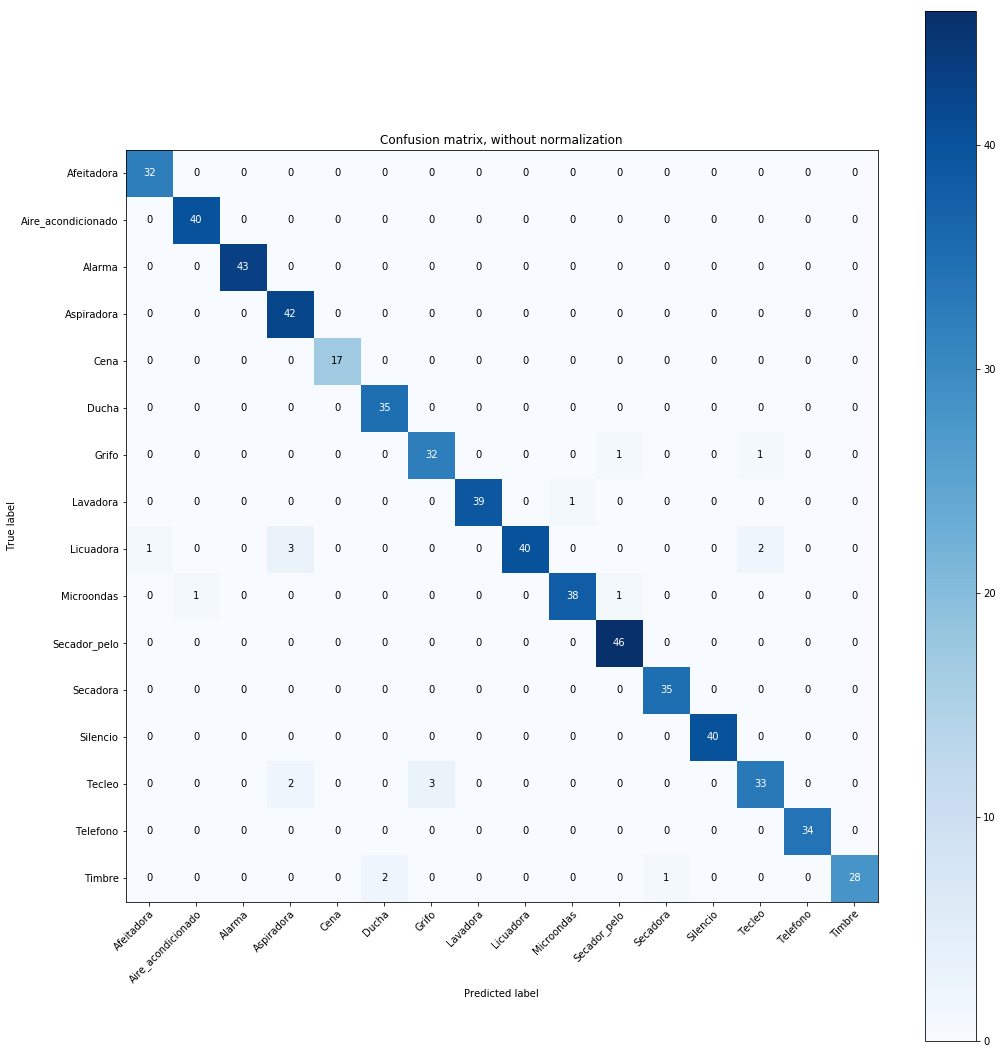

In [11]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [12]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [14]:
classifier = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [16]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [17]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [18]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [19]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

Y para terminar, mirando las ROC Curve, podemos concluir que ambos modelos son muy similares, dado que las AUC son prácticamente los mismos.

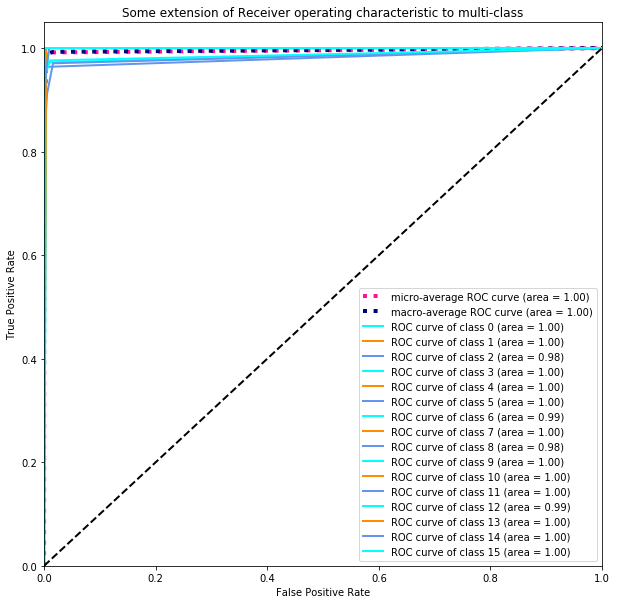

In [20]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

A continuación voy a probar con los modelos SVC, LinearRegression y LogisticRegression.

Como se va a poder ver en los resultados más abajo, estos 3 modelos dan unos resultados muy malos, por lo que los voy a deshechar y no continuar con ellos.

# SVC

In [33]:
def readCsvToDataFrame(path):
    theDataFrame= pandas.read_csv(path)
    return theDataFrame

data = readCsvToDataFrame('data.csv')

In [34]:
y = pd.get_dummies(data=data.momento_aux)
X = data.loc[:, data.columns != 'momento_aux']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [35]:
clf = OneVsRestClassifier(svm.SVC(kernel='rbf', gamma = 'scale', probability=True))

In [36]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.09106239460370995

In [37]:
actual_values = y_test.values.argmax(axis=1)
predictions = clf.predict(X_test).argmax(axis=1)

accuracy_score = accuracy_score(actual_values, predictions)
accuracy_score

0.163575042158516

In [38]:
balanced_accuracy_score = balanced_accuracy_score(actual_values, predictions)
balanced_accuracy_score

0.1452205882352941

In [39]:
precision = pd.DataFrame(precision_score(actual_values, predictions,average=None))
recall = pd.DataFrame(recall_score(actual_values, predictions,average=None))
f1_score = pd.DataFrame(f1_score(actual_values, predictions, average=None))

precision_recall = pd.concat([precision, recall, f1_score], axis=1)
precision_recall.columns = ['precision', 'recall', 'f1_score']
precision_recall.index = ['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                          'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                          'Licuadora', 'Alarma', 'Grifo', 'Microondas']
precision_recall.index.name = 'momento_aux'
precision_recall

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,precision,recall,f1_score
momento_aux,,,
Cena,0.080675,1.000000,0.149306
Ducha,0.000000,0.000000,0.000000
Lavadora,0.000000,0.000000,0.000000
Aspiradora,0.000000,0.000000,0.000000
Afeitadora,0.000000,0.000000,0.000000
Secador_pelo,0.733333,0.323529,0.448980
Aire_acondicionado,0.000000,0.000000,0.000000
Telefono,0.000000,0.000000,0.000000
Tecleo,0.000000,0.000000,0.000000


Confusion matrix, without normalization
[[43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [32  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [23  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [27  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0]
 [43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 43  0  0  0]
 [37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


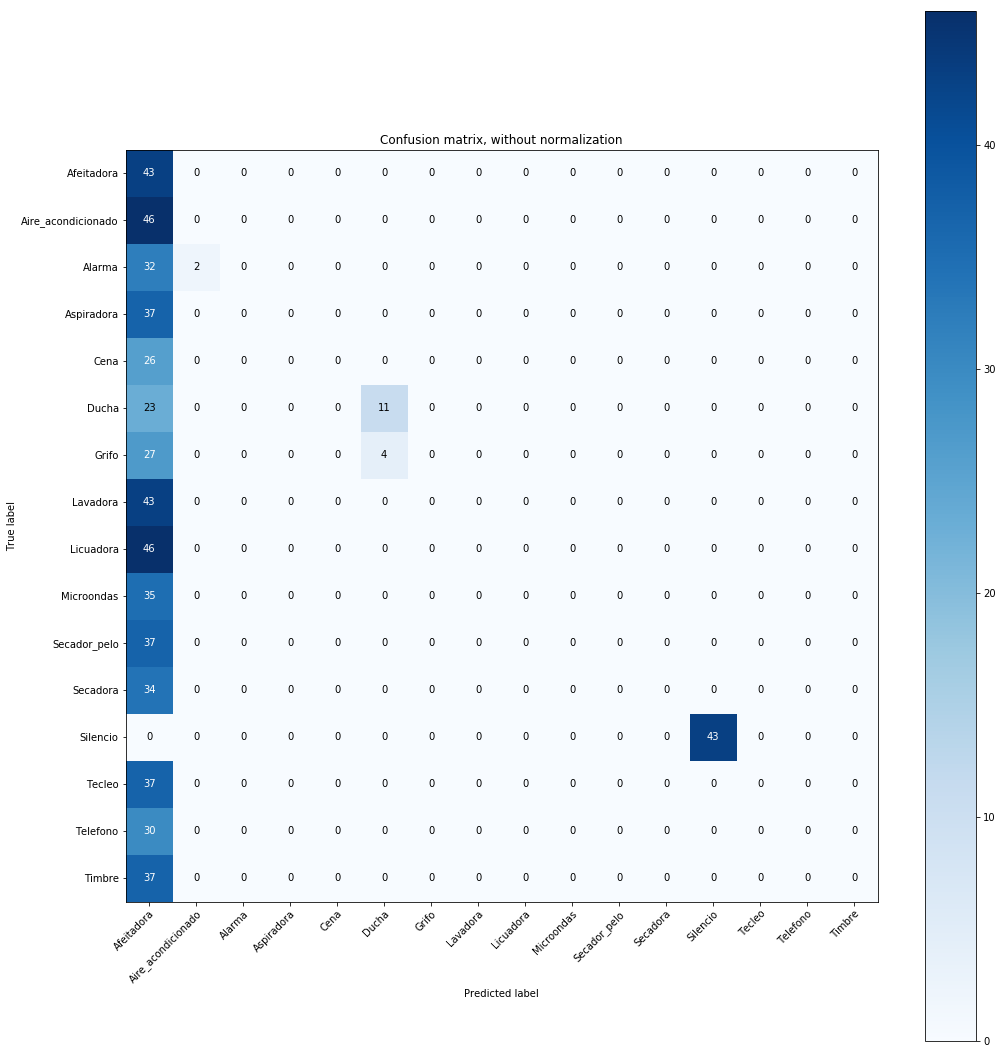

In [40]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_values, predictions, y.columns)

In [41]:
y = label_binarize(y, classes=['Cena', 'Ducha', 'Lavadora', 'Aspiradora', 'Afeitadora', 'Secador_pelo', 
                               'Aire_acondicionado', 'Telefono', 'Tecleo', 'Silencio', 'Secadora', 'Timbre', 
                               'Licuadora', 'Alarma', 'Grifo', 'Microondas'])
n_classes = y.shape[1]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [43]:
classifier = OneVsRestClassifier(svm.SVC(kernel='rbf', gamma = 'scale', probability=True))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [44]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [45]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [46]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [47]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [48]:
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

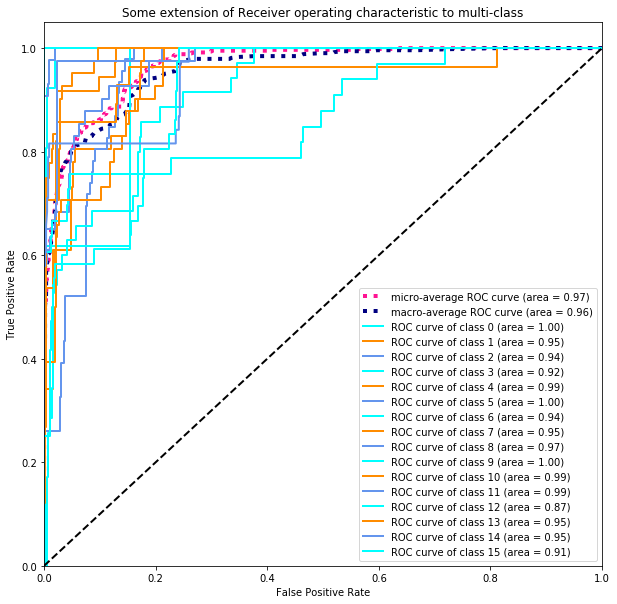

In [49]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# LinearRegression

In [50]:
y = pd.get_dummies(data=data.momento_aux)
X = data.loc[:, data.columns != 'momento_aux']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [51]:
clf = OneVsRestClassifier(linear_model.LinearRegression())
scores = cross_val_score(clf, X, y, cv=20)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00675676
 0.         0.06081081 0.04054054 0.14864865 0.02702703 0.
 0.         0.        ]
Accuracy: 0.01 (+/- 0.07)


In [52]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.11804384485666104

# LogisticRegression

In [53]:
y = pd.get_dummies(data=data.momento_aux)
X = data.loc[:, data.columns != 'momento_aux']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [66]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-package

0.4536256323777403